In [8]:
import backtrader as bt
import backtrader.indicators as btind
import backtrader.feeds as btfeeds

import pandas as pd 
import os, sys
from datetime import datetime


import matplotlib.pylab as plt 
%matplotlib inline

In [53]:
# AAPL = bt.feeds.YahooFinanceCSVData(dataname='AAPL') 


skiprows = 1  
header = None 

cwd = os.getcwd()
filename = cwd + '/data/TSLA.csv'
df_TSLA = pd.read_csv(filename,  header=header, index_col=0)
# df_TSLA = pd.read_csv(filename, skiprows=skiprows, header=header, parse_dates=True, index_col=0)


TSLA_from_file = bt.feeds.YahooFinanceCSVData(dataname = filename)
len(TSLA)

# currently not working 
TSLA_from_df = bt.feeds.PandasData(dataname=df_TSLA, openinterest=None)
df_TSLA.head()


,1,2,3,4,5,6
0,,,,,,
Date,Open,High,Low,Close,Adj Close,Volume
2020-04-15,148.399994,150.626007,142.000000,145.966003,145.966003,117885000
2020-04-16,143.388000,151.889999,141.343994,149.042007,149.042007,103289500
2020-04-17,154.455994,154.990005,149.531998,150.778000,150.778000,65641000
2020-04-20,146.539993,153.113998,142.442001,149.272003,149.272003,73733000


In [62]:
df_TSLA.index

df_TSLA.index = pd.to_datetime(df_TSLA.index, format='%Y-%m-%d', errors='ignore')

df_TSLA


,1,2,3,4,5,6
0,,,,,,
Date,Open,High,Low,Close,Adj Close,Volume
2020-04-15,148.399994,150.626007,142.000000,145.966003,145.966003,117885000
2020-04-16,143.388000,151.889999,141.343994,149.042007,149.042007,103289500
2020-04-17,154.455994,154.990005,149.531998,150.778000,150.778000,65641000
2020-04-20,146.539993,153.113998,142.442001,149.272003,149.272003,73733000
...,...,...,...,...,...,...
2021-04-08,677.380005,689.549988,671.650024,683.799988,683.799988,23924300
2021-04-09,677.770020,680.969971,669.429993,677.020020,677.020020,21402600
2021-04-12,685.700012,704.799988,682.090027,701.979980,701.979980,29135700


In [67]:
data = TSLA_from_file

In [71]:
class Strat1_2BD_5BH(bt.Strategy):
    
    params = (
        ('exitbars',10), # Tuple of tuples containing any variable settings required by the strategy.
    )

    def __init__(self):
        self.dataclose= self.datas[0].close    # Keep a reference to the "close" line in the data[0] dataseries
        self.order = None # Property to keep track of pending orders.  There are no orders when the strategy is initialized.
        self.buyprice = None
        self.buycomm = None
    
    
    def log(self, txt, dt=None):
        # Logging function for the strategy.  'txt' is the statement and 'dt' can be used to specify a specific datetime
        dt = dt or self.datas[0].datetime.date(0)
        print('{0},{1}'.format(dt.isoformat(),txt))
    
    def notify_order(self, order):
        # 1. If order is submitted/accepted, do nothing 
        if order.status in [order.Submitted, order.Accepted]:
            return
        # 2. If order is buy/sell executed, report price executed
        if order.status in [order.Completed]: 
            if order.isbuy():
                self.log('BUY EXECUTED, Price: {0:8.2f}, Cost: {1:8.2f}, Comm: {2:8.2f}'.format(
                    order.executed.price,
                    order.executed.value,
                    order.executed.comm))
                
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:
                self.log('SELL EXECUTED, {0:8.2f}, Cost: {1:8.2f}, Comm{2:8.2f}'.format(
                    order.executed.price, 
                    order.executed.value,
                    order.executed.comm))
            
            self.bar_executed = len(self) #when was trade executed
        # 3. If order is canceled/margin/rejected, report order canceled
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
            
        self.order = None
    
    def notify_trade(self,trade):
        if not trade.isclosed:
            return
        
        self.log('OPERATION PROFIT, GROSS {0:8.2f}, NET {1:8.2f}'.format(
            trade.pnl, trade.pnlcomm))
    
    def next(self):
        # Log the closing prices of the series from the reference
        self.log('Close, {0:8.2f}'.format(self.dataclose[0]))

        if self.order: # check if order is pending, if so, then break out
            return
                
        # since there is no order pending, are we in the market?    
        if not self.position: # not in the market
            if self.dataclose[0] < self.dataclose[-1]:
                if self.dataclose[-1] < self.dataclose[-2]:
                    self.log('BUY CREATE {0:8.2f}'.format(self.dataclose[0]))
                    self.order = self.buy()           
        else: # in the market
            if len(self) >= (self.bar_executed+self.params.exitbars):
                self.log('SELL CREATE, {0:8.2f}'.format(self.dataclose[0]))
                self.order = self.sell()

In [73]:
cerebro = bt.Cerebro()  # We initialize the `cerebro` backtester.
cerebro.adddata(data) # We add the dataset in the Data cell.
cerebro.addstrategy(Strat1_2BD_5BH, exitbars=10) # We add the strategy described in the `Strategy class` cell
cerebro.addsizer(bt.sizers.FixedSize, stake=10)
cerebro.broker.setcash(100000.0) # We set an initial trading capital of $100,000
cerebro.broker.setcommission(commission=0.001) # We set broker comissions of 0.1%

In [74]:
print('Starting Portfolio Value: {0:8.2f}'.format(cerebro.broker.getvalue()))
cerebro.run()
print('Final Portfolio Value: {0:8.2f}'.format(cerebro.broker.getvalue()))

Starting Portfolio Value: 100000.00
2020-04-15,Close,   145.97
2020-04-15,BUY CREATE   145.97
2020-04-16,BUY EXECUTED, Price:   143.39, Cost:  1433.90, Comm:     1.43
2020-04-16,Close,   149.04
2020-04-17,Close,   150.78
2020-04-20,Close,   149.27
2020-04-21,Close,   137.34
2020-04-22,Close,   146.42
2020-04-23,Close,   141.13
2020-04-24,Close,   145.03
2020-04-27,Close,   159.75
2020-04-28,Close,   153.82
2020-04-29,Close,   160.10
2020-04-30,Close,   156.38
2020-04-30,SELL CREATE,   156.38
2020-05-01,SELL EXECUTED,   151.00, Cost:  1433.90, Comm    1.51
2020-05-01,OPERATION PROFIT, GROSS    76.10, NET    73.16
2020-05-01,Close,   140.26
2020-05-01,BUY CREATE   140.26
2020-05-04,BUY EXECUTED, Price:   140.20, Cost:  1402.00, Comm:     1.40
2020-05-04,Close,   152.24
2020-05-05,Close,   153.64
2020-05-06,Close,   156.52
2020-05-07,Close,   156.01
2020-05-08,Close,   163.88
2020-05-11,Close,   162.26
2020-05-12,Close,   161.88
2020-05-13,Close,   158.19
2020-05-14,Close,   160.67
2020-0

In [75]:
cerebro = bt.Cerebro()  
cerebro.adddata(data) 
cerebro.addstrategy(Strat1_2BD_5BH, exitbars=10) 
cerebro.addsizer(bt.sizers.FixedSize,stake=10)
cerebro.broker.setcash(100000.0) 
cerebro.broker.setcommission(commission=0.001) 

In [76]:
print('Starting Portfolio Value: {0:8.2f}'.format(cerebro.broker.getvalue()))
cerebro.run()
print('Final Portfolio Value: {0:8.2f}'.format(cerebro.broker.getvalue()))

Starting Portfolio Value: 100000.00
2020-04-15,Close,   145.97
2020-04-15,BUY CREATE   145.97
2020-04-16,BUY EXECUTED, Price:   143.39, Cost:  1433.90, Comm:     1.43
2020-04-16,Close,   149.04
2020-04-17,Close,   150.78
2020-04-20,Close,   149.27
2020-04-21,Close,   137.34
2020-04-22,Close,   146.42
2020-04-23,Close,   141.13
2020-04-24,Close,   145.03
2020-04-27,Close,   159.75
2020-04-28,Close,   153.82
2020-04-29,Close,   160.10
2020-04-30,Close,   156.38
2020-04-30,SELL CREATE,   156.38
2020-05-01,SELL EXECUTED,   151.00, Cost:  1433.90, Comm    1.51
2020-05-01,OPERATION PROFIT, GROSS    76.10, NET    73.16
2020-05-01,Close,   140.26
2020-05-01,BUY CREATE   140.26
2020-05-04,BUY EXECUTED, Price:   140.20, Cost:  1402.00, Comm:     1.40
2020-05-04,Close,   152.24
2020-05-05,Close,   153.64
2020-05-06,Close,   156.52
2020-05-07,Close,   156.01
2020-05-08,Close,   163.88
2020-05-11,Close,   162.26
2020-05-12,Close,   161.88
2020-05-13,Close,   158.19
2020-05-14,Close,   160.67
2020-0

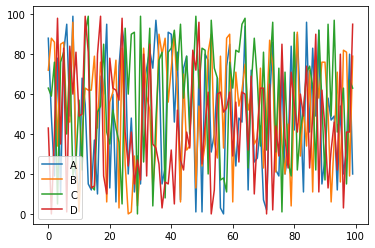

In [77]:
import numpy as np
import pandas as pd

df = pd.DataFrame(np.random.randint(0,100,size=(100,4)),columns = list('ABCD'))
df.head()
df.plot()

In [ ]:
class MyStrategy(bt.Strategy):
    def next(self):
        pass

cerebro = bt.Cerebro()
cerebro.addstrategy(MyStrategy)

cerebro.run()


from datetime import datetime

class PrintClose(bt.Strategy):
    def __init__(self):
        self.dataclose = self.datas[0].close
        # print(self.datas[0].close[1])

    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        #print('dt:', self.datas[0].datetime.date(0))
        print(self.datas[0].datetime.date(0), dt, txt)
        # print(f'{self.datas[0].datetime.date(0).isoformat()} {txt}')

    def next(self):
        self.log('Close', self.dataclose[0])
        cerebro = bt.Cerebro()
        
data = bt.feeds.YahooFinanceCSVData(dataname='AAPL') 
cerebro.adddata(data)
cerebro.addstrategy(PrintClose)
# cerebro.run()

start_portfolio_value = cerebro.broker.getvalue()

cerebro.run()

end_portfolio_value = cerebro.broker.getvalue()
pnl = end_portfolio_value - start_portfolio_value
print(f'Starting Portfolio Value: {start_portfolio_value:2f}')
print(f'Final Portfolio Value: {end_portfolio_value:2f}')
print(f'PnL: {pnl:.2f}')

In [ ]:
import pandas as pd 
import os

cwd = os.getcwd()
print(cwd)

filename = cwd + '/data/TSLA.csv'
df = pd.read_csv(filename)

df.head()


In [ ]:
import pandas as pd 
import os

cwd = os.getcwd()
print(cwd)


skiprows = 1  
header = None 

filename = cwd + '/data/TSLA.csv'
df = pd.read_csv(filename, skiprows=skiprows, header=header, parse_dates=True, index_col=0)

data = bt.feeds.PandasData(dataname=df)

In [ ]:
data 

In [ ]:
import datetime
import backtrader as bt 
# from strategies import * 

cerebro = bt.Cerebro()
data = bt.feeds.YahooFinanceCSVData(
    dataname='./data/TSLA.csv',
    fromdate=datetime.datetime(2016, 1, 1),
    todate=datetime.datetime(2017, 12, 25),
)
cerebro.adddata(data)

# Add strategy to Cerebro
cerebro.addstrategy(PrintClose)

# Default position size
cerebro.addsizer(bt.sizers.SizerFix, stake=3)

# if __name__ == '__main__':
    # Run Cerebro Engine
start_portfolio_value = cerebro.broker.getvalue()

cerebro.run()

end_portfolio_value = cerebro.broker.getvalue()
pnl = end_portfolio_value - start_portfolio_value
print(f'Starting Portfolio Value: {start_portfolio_value:2f}')
print(f'Final Portfolio Value: {end_portfolio_value:2f}')
print(f'PnL: {pnl:.2f}')

In [ ]:
data = bt.feeds.YahooFinanceCSVData(
    dataname='./data/TSLA.csv'
)
data

In [ ]:
from datetime import datetime
import backtrader as bt
import matplotlib.pylab as plt 
%matplotlib inline


plt.rcParams["figure.figsize"] = (20,10)


class SmaCross(bt.SignalStrategy):
    def __init__(self):
        sma1, sma2 = bt.ind.SMA(period=10), bt.ind.SMA(period=20)
        crossover = bt.ind.CrossOver(sma1, sma2)
        self.signal_add(bt.SIGNAL_LONG, crossover)

if __name__ == '__main__':
    cerebro = bt.Cerebro()
    cerebro.addstrategy(SmaCross)
    cerebro.broker.setcash(1337.0)
    cerebro.broker.setcommission(commission=0.001)

    data = bt.feeds.YahooFinanceData(dataname='AAPL',
                                     fromdate=datetime(2017, 1, 1),
                                     todate=datetime(2017, 12, 31))
    cerebro.adddata(data)
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    cerebro.run()
    print('Ending Portfolio Value: %.2f' % cerebro.broker.getvalue())
    cerebro.plot(iplot=False)

In [ ]:
class DonchianChannels(bt.Indicator):
    '''
    Params Note:
      - `lookback` (default: -1)
        If `-1`, the bars to consider will start 1 bar in the past and the
        current high/low may break through the channel.
        If `0`, the current prices will be considered for the Donchian
        Channel. This means that the price will **NEVER** break through the
        upper/lower channel bands.
    '''

    alias = ('DCH', 'DonchianChannel',)

    lines = ('dcm', 'dch', 'dcl',)  # dc middle, dc high, dc low
    params = dict(
        period=20,
        lookback=-1,  # consider current bar or not
    )

    plotinfo = dict(subplot=False)  # plot along with data
    plotlines = dict(
        dcm=dict(ls='--'),  # dashed line
        dch=dict(_samecolor=True),  # use same color as prev line (dcm)
        dcl=dict(_samecolor=True),  # use same color as prev line (dch)
    )

    def __init__(self):
        hi, lo = self.data.high, self.data.low
        if self.p.lookback:  # move backwards as needed
            hi, lo = hi(self.p.lookback), lo(self.p.lookback)

        self.l.dch = bt.ind.Highest(hi, period=self.p.period)
        self.l.dcl = bt.ind.Lowest(lo, period=self.p.period)
        self.l.dcm = (self.l.dch + self.l.dcl) / 2.0  # avg of the above


class MyStrategy(bt.Strategy):
    def __init__(self):
        self.myind = DonchianChannels()

    def next(self):
        if self.data[0] > self.myind.dch[0]:
            self.buy()
        elif self.data[0] < self.myind.dcl[0]:
            self.sell()

if __name__ == '__main__':
    cerebro = bt.Cerebro()
    cerebro.addstrategy(MyStrategy)
    cerebro.broker.setcash(1337.0)
    cerebro.broker.setcommission(commission=0.001)

    data = bt.feeds.YahooFinanceData(dataname='AAPL',
                                     fromdate=datetime(2017, 1, 1),
                                     todate=datetime(2017, 12, 31))
    cerebro.adddata(data)
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    cerebro.run()
    print('Ending Portfolio Value: %.2f' % cerebro.broker.getvalue())
    cerebro.plot()

In [ ]:
type(data)

In [ ]:
it = iter(data)
next(it)
 

In [ ]:
?backtrader.feeds

In [ ]:
from __future__ import (absolute_import, division, print_function, unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

# Import the backtrader platform
import backtrader as bt


# Create a Stratey
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print(self.datas[0])
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])


if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(TestStrategy)

    # Datas are in a subfolder of the samples. Need to find where the script is
    # because it could have been called from anywhere
    modpath = os.path.dirname(os.path.abspath(sys.argv[0]))
    datapath = os.path.join(modpath, './data/TSLA.csv')

    # Create a Data Feed
    data = bt.feeds.YahooFinanceCSVData(
        dataname=datapath,
        # Do not pass values before this date
        # fromdate=datetime.datetime(2000, 1, 1),
        # Do not pass values before this date
        # todate=datetime.datetime(2000, 12, 31),
        # Do not pass values after this date
        reverse=False)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(100000.0)

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

In [ ]:
test = TestStrategy()
test.data